In [4]:
# Cell 1 — Imports & file path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import joblib

DATA_PATH = "titanic.csv"   # change if needed
print("Imports done.")

Imports done.


In [5]:
# Cell 2 — Load dataset and quick checks
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nColumns:", list(df.columns))

Shape: (418, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [6]:
# Cell 3 — Basic preprocessing (drop bad cols, simple features)
df2 = df.copy()

# Drop obviously unhelpful columns if present
for c in ["PassengerId", "Ticket", "Cabin"]:
    if c in df2.columns:
        df2.drop(columns=c, inplace=True)

# Create FamilySize if possible
if {"SibSp", "Parch"}.issubset(df2.columns):
    df2["FamilySize"] = df2["SibSp"] + df2["Parch"] + 1

# Extract Title from Name if Name exists (if not, skip)
if "Name" in df2.columns:
    df2["Title"] = df2["Name"].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
    df2["Title"] = df2["Title"].replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"})
    rare = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    df2["Title"] = df2["Title"].replace(rare, "Rare")
    df2.drop(columns=["Name"], inplace=True)

print("After basic preprocessing shape:", df2.shape)
display(df2.head())

After basic preprocessing shape: (418, 10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,0,3,male,34.5,0,0,7.8292,Q,1,Mr
1,1,3,female,47.0,1,0,7.0000,S,2,Mrs
2,0,2,male,62.0,0,0,9.6875,Q,1,Mr
3,0,3,male,27.0,0,0,8.6625,S,1,Mr
4,1,3,female,22.0,1,1,12.2875,S,3,Mrs


In [7]:
# Cell 4 — Prepare feature list and target; handle missing columns defensively
target = "Survived"
if target not in df2.columns:
    raise KeyError("Target column 'Survived' not found in the dataset.")

# Choose features to keep if present
candidate_features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","FamilySize","Title"]
features = [c for c in candidate_features if c in df2.columns]
print("Using features:", features)
X = df2[features].copy()
y = df2[target].copy()

Using features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']


In [10]:
# ✅ Cell 5 (Fixed) — Build preprocessing pipeline safely for any sklearn version
from sklearn import __version__ as skl_version

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", cat_features)

# Choose the right argument name based on version
sparse_arg = {}
if int(skl_version.split('.')[1]) >= 2:  # sklearn >= 1.2
    sparse_arg = {'sparse_output': False}
else:
    sparse_arg = {'sparse': False}

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", **sparse_arg))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, cat_features)
], remainder="drop")

print("Preprocessing pipeline ready.")

Numeric: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
Categorical: ['Sex', 'Embarked', 'Title']
Preprocessing pipeline ready.


In [11]:
# Cell 6 — Create full pipeline with logistic regression
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train/test split with stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Fit model
pipe.fit(X_train, y_train)
print("Model trained.")

Train size: (334, 9) Test size: (84, 9)
Model trained.


Test Accuracy: 1.0000

Confusion Matrix:
 [[53  0]
 [ 0 31]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



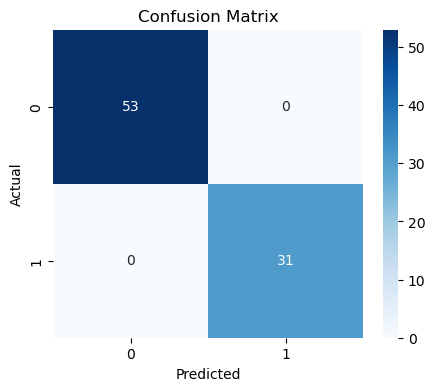

In [12]:
# Cell 7 — Evaluation on test set (accuracy, confusion matrix, classification report)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

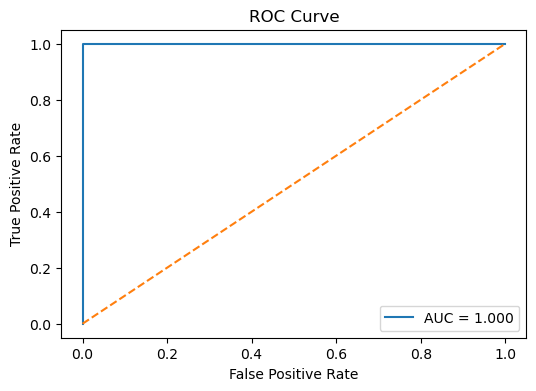

In [13]:
# Cell 8 — ROC curve (if probabilities available)
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
else:
    print("predict_proba not available for classifier.")

In [14]:
# Cell 9 — Stratified cross-validation for a more reliable accuracy estimate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
print("CV scores:", np.round(cv_scores,4))
print("CV mean accuracy:", np.round(cv_scores.mean(),4))

CV scores: [1. 1. 1. 1. 1.]
CV mean accuracy: 1.0


In [15]:
# Diagnostic cell — check for data leakage or overly strong features
print("Columns used in training:")
print(list(X.columns))
print("\nCorrelation of each feature with Survived:\n")
print(df2.corr(numeric_only=True)["Survived"].sort_values(ascending=False))

# Check number of unique values in each column
print("\nUnique value counts per column:")
print(df2.nunique())

Columns used in training:
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']

Correlation of each feature with Survived:

Survived      1.000000
Fare          0.191514
FamilySize    0.161803
Parch         0.159120
SibSp         0.099943
Age          -0.000013
Pclass       -0.108615
Name: Survived, dtype: float64

Unique value counts per column:
Survived        2
Pclass          3
Sex             2
Age            79
SibSp           7
Parch           8
Fare          169
Embarked        3
FamilySize      9
Title           5
dtype: int64
